In [218]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import hypernetx.algorithms.hypergraph_modularity as hmod
import pandas as pd
import igraph as ig
import hypernetx as hnx
import statistics
import itertools
import math
import HAT
import community ## package python-louvain
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.simplefilter(action='ignore')

In [4]:
## get intra-chromosomal genes

dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_poreC_explore/'
chromSizes = pd.read_csv(f'{dataDir}hg38.chromSizes',sep="\t", names = ['chr','size']).set_index('chr')['size'].to_dict()
readConcatemersWClosestGene = f'{dataDir}fragFile_sorted_wClosestGene.bed.gz'
colnames = ["chr","start","end","readID","geneChr","geneStart","geneEnd","strand","geneID","bioType","geneName","dist"]

fullBed = pd.read_csv(readConcatemersWClosestGene,sep = "\t",names = colnames)

In [99]:
chr19 = fullBed[fullBed['chr']=="chr19"]
chrBins = [x for x in range(0,chromSizes['chr19']+5*10**5,5*10**5)]
chr19_binned = pd.cut(chr19['start'],bins = chrBins, labels = ["Bin_"+str(i+1) for i in range(len(chrBins)-1)]).rename("binID")
chr19_wBinID = chr19.merge(chr19_binned,left_index=True,right_index=True)

In [100]:
chr19IncDF = pd.pivot_table(data=chr19_wBinID[['readID', 'binID']], index='binID', columns='readID', aggfunc=lambda x: 1, fill_value=0)
chr19IncDF.shape

(114, 56155)

In [101]:
colSums_chr19IncDF = chr19IncDF.sum()
intraChrom19 = chr19IncDF.loc[:, colSums_chr19IncDF >=3]
intraChrom19.shape
intraChrom19.to_csv('interChrom19_hnx.tab',sep = "\t")

In [102]:
ic19_full = hnx.Hypergraph.from_incidence_dataframe(intraChrom19)
print(ic19_full.number_of_nodes())
print(ic19_full.number_of_edges())

114
3360


In [103]:
ic19_multiedge = ic19_full.collapse_edges(use_reps = True, return_counts = True)
print(ic19_multiedge.number_of_nodes())
print(ic19_multiedge.number_of_edges())

114
2968


In [104]:
ic19_multiedge_incidence = pd.DataFrame(ic19_multiedge.incidence_matrix().todense())
colsums_reducedDF = ic19_multiedge_incidence.sum(axis = 0).tolist()

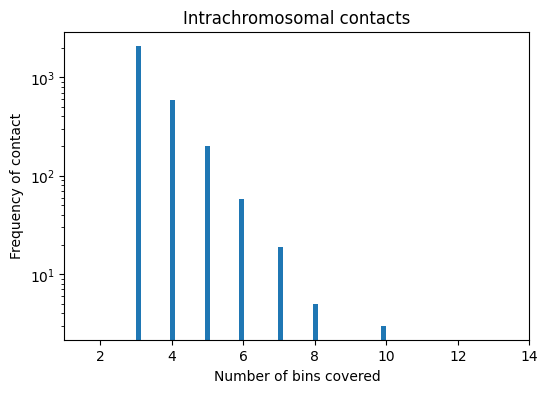

In [105]:
# Generate a histogram
plt.figure(figsize=(6,4))
plt.hist(colsums_reducedDF, bins='auto')

plt.xlim(xmin=1, xmax=14)
plt.yscale('log')

# Add labels and title
plt.xlabel('Number of bins covered')
plt.ylabel('Frequency of contact')
plt.title('Intrachromosomal contacts')

# Display the histogram
plt.show()

In [106]:
ic19_multiedge.is_connected(s=1), ic19_multiedge.is_connected(s=2), ic19_multiedge.is_connected(s=3),ic19_multiedge.is_connected(s=4)

(True, False, False, False)

In [107]:
ic19_multiedge.degree('Bin_1',s = 1), ic19_multiedge.degree('Bin_1',s = 5), ic19_multiedge.degree('Bin_1',s = 8)

(40, 4, 0)

In [205]:
A, names = ic19_multiedge.adjacency_matrix(s = 15, index = True)
A = A.todense()
g = ic19_multiedge.get_linegraph(s = 15, edges = False)
A.shape


(114, 114)

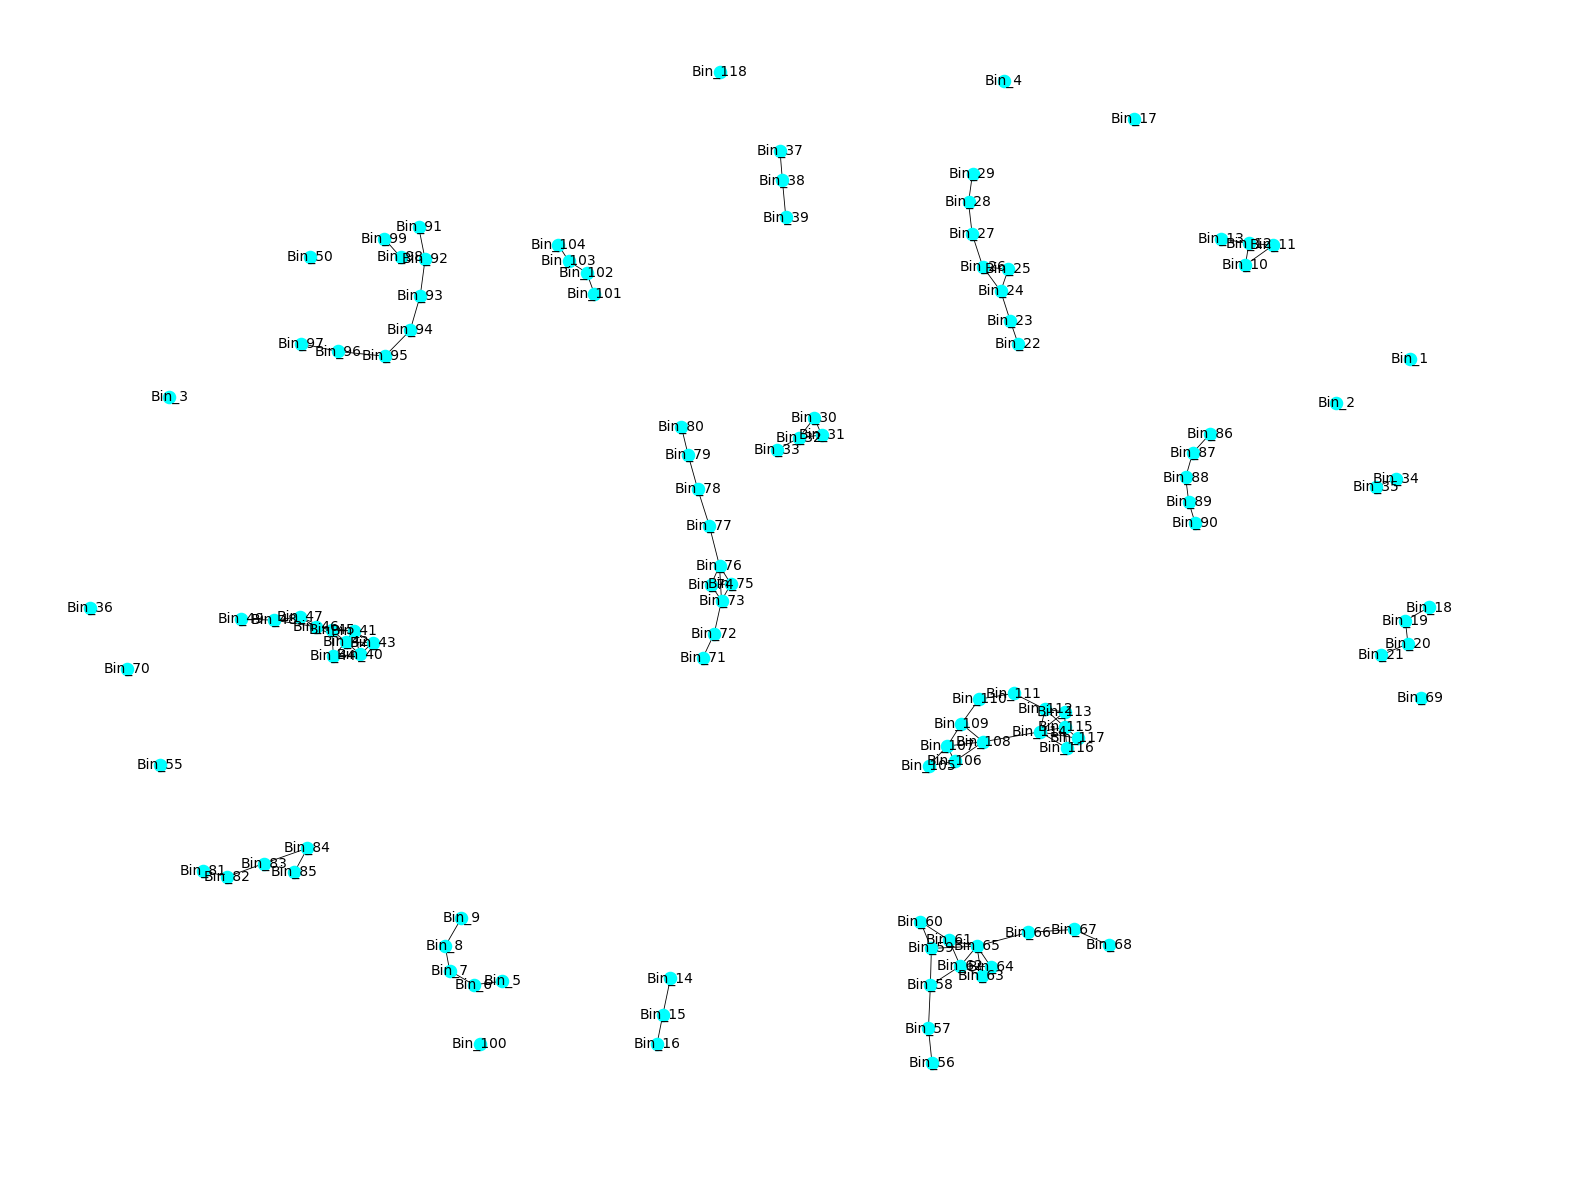

In [208]:
fig, ax = plt.subplots(figsize=(8, 6))
nx.draw(g, with_labels = True, node_size = 15, node_color = "cyan",font_size=5, width = 0.3)
plt.axis('off')
plt.tight_layout()

# Show the plot
plt.show()

In [238]:
graphComps = ic19_multiedge.s_component_subgraphs(s = 15, edges = False,return_singletons=False, name=None)

In [145]:
for index, comp in enumerate(graphComps):
    print(index, comp.number_of_nodes())
    print([n for n in comp.nodes])

0 4
['Bin_11', 'Bin_13', 'Bin_12', 'Bin_10']
1 4
['Bin_102', 'Bin_101', 'Bin_103', 'Bin_104']
2 13
['Bin_110', 'Bin_111', 'Bin_108', 'Bin_113', 'Bin_106', 'Bin_116', 'Bin_107', 'Bin_112', 'Bin_115', 'Bin_117', 'Bin_105', 'Bin_114', 'Bin_109']
3 3
['Bin_15', 'Bin_14', 'Bin_16']
4 4
['Bin_18', 'Bin_20', 'Bin_21', 'Bin_19']
5 8
['Bin_29', 'Bin_25', 'Bin_28', 'Bin_24', 'Bin_27', 'Bin_22', 'Bin_26', 'Bin_23']
6 4
['Bin_32', 'Bin_33', 'Bin_31', 'Bin_30']
7 2
['Bin_34', 'Bin_35']
8 3
['Bin_38', 'Bin_39', 'Bin_37']
9 10
['Bin_46', 'Bin_42', 'Bin_47', 'Bin_48', 'Bin_45', 'Bin_49', 'Bin_40', 'Bin_43', 'Bin_44', 'Bin_41']
10 5
['Bin_9', 'Bin_7', 'Bin_5', 'Bin_6', 'Bin_8']
11 13
['Bin_68', 'Bin_60', 'Bin_58', 'Bin_67', 'Bin_64', 'Bin_57', 'Bin_63', 'Bin_66', 'Bin_65', 'Bin_62', 'Bin_59', 'Bin_61', 'Bin_56']
12 10
['Bin_77', 'Bin_79', 'Bin_80', 'Bin_71', 'Bin_76', 'Bin_74', 'Bin_72', 'Bin_75', 'Bin_73', 'Bin_78']
13 5
['Bin_84', 'Bin_85', 'Bin_81', 'Bin_82', 'Bin_83']
14 5
['Bin_90', 'Bin_89', 'Bin

In [239]:
item_index = 2
smallSG = next(itertools.islice(graphComps, item_index, item_index+1))


In [240]:
smallIncDF = smallSG.incidence_dataframe()
smallSG.number_of_edges(), smallSG.number_of_nodes()

(894, 13)

In [241]:
colSums_smallSG = smallIncDF.sum()
smallSG_multiEdge = smallIncDF.loc[:, colSums_smallSG >=2]
smallSG_multiEdge_HG = hnx.Hypergraph.from_incidence_dataframe(smallSG_multiEdge)

In [242]:
smallSG_multiEdge_HG.number_of_edges()

418

TypeError: Axes.set_title() got multiple values for argument 'label'

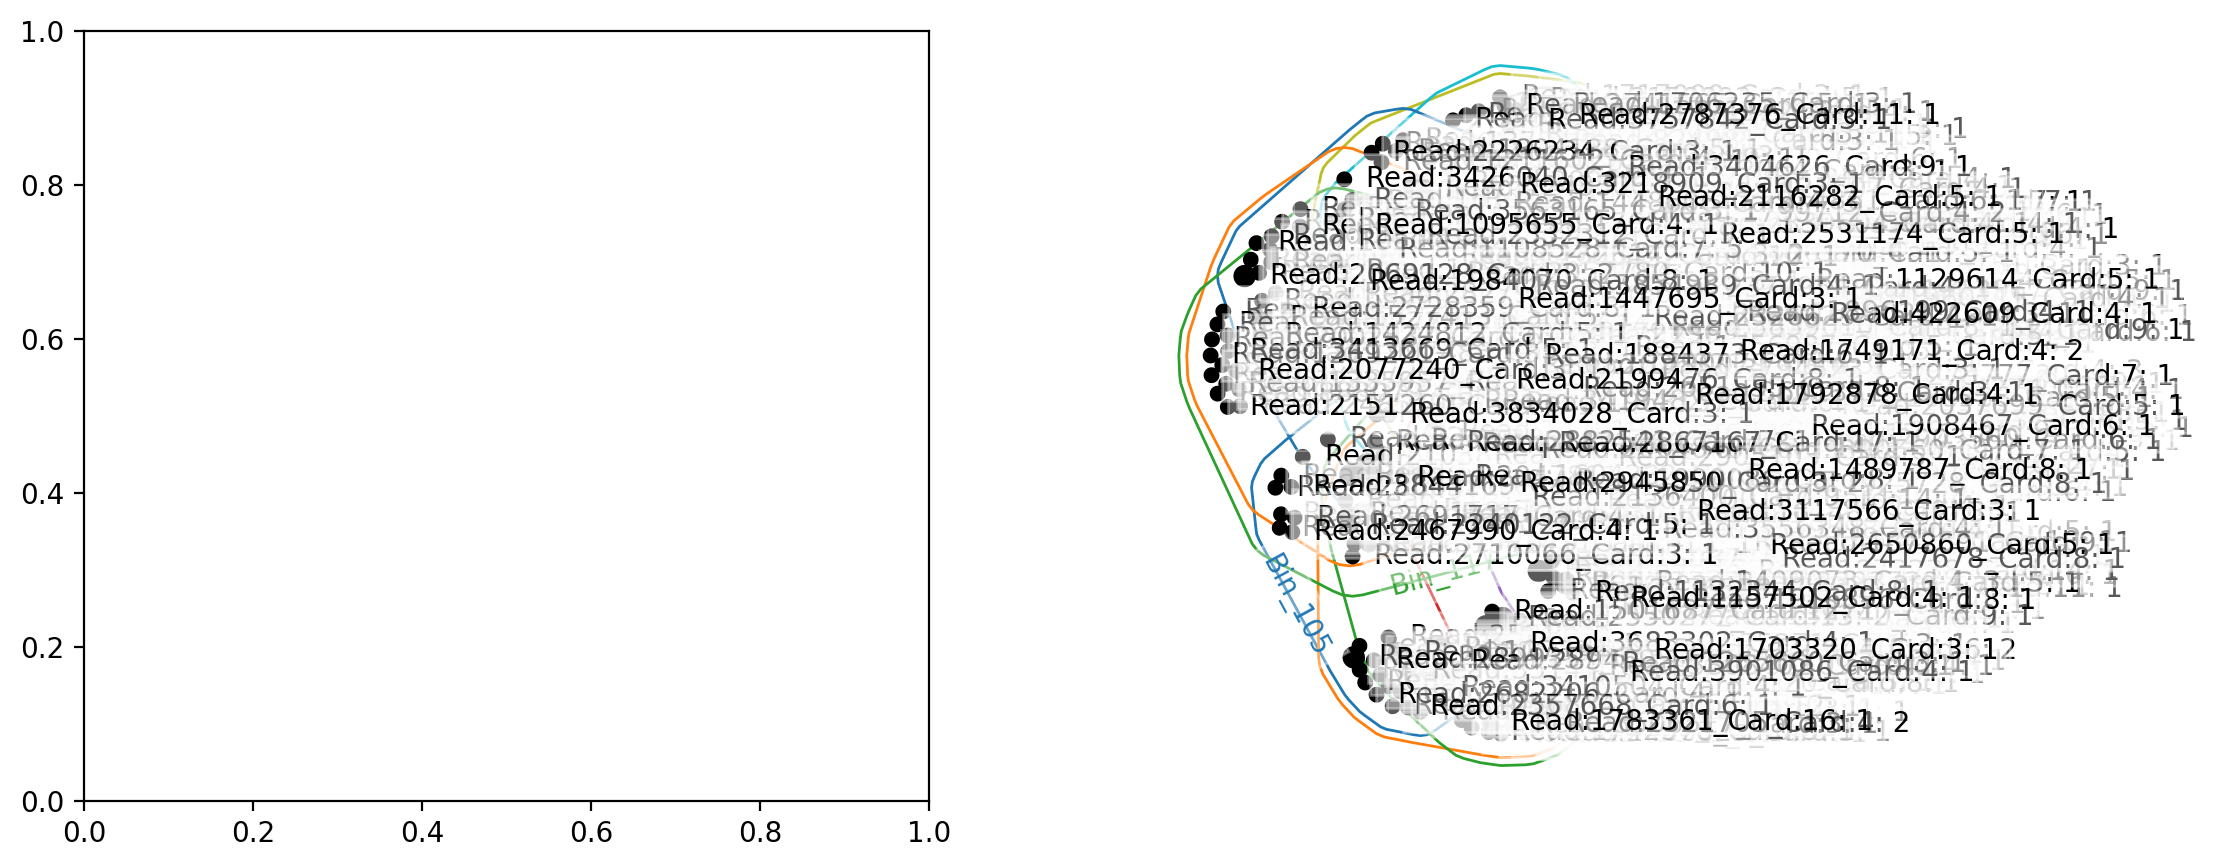

In [245]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
HD = smallSG_multiEdge_HG.dual()
hnx.draw(smallSG_multiEdge_HG,ax=ax[0])
ax[0].set_title("Subgraph",fontsize=15)
hnx.draw(HD,ax=ax[1])
ax[1].set_title("Subgraph-dual",fontsize=15)

In [246]:
subgraph_fullDF = chr19_wBinID[chr19_wBinID['binID'].isin(["Bin_"+str(x) for x in range(81,85)])]

In [247]:
subgraphIncDF = pd.pivot_table(data=subgraph_fullDF[['readID', 'geneName']], index='geneName', columns='readID', aggfunc=lambda x: 1, fill_value=0)
sg_gene = hnx.Hypergraph.from_incidence_dataframe(subgraphIncDF)
print(sg_gene.number_of_nodes(),sg_gene.number_of_edges())

65 2613


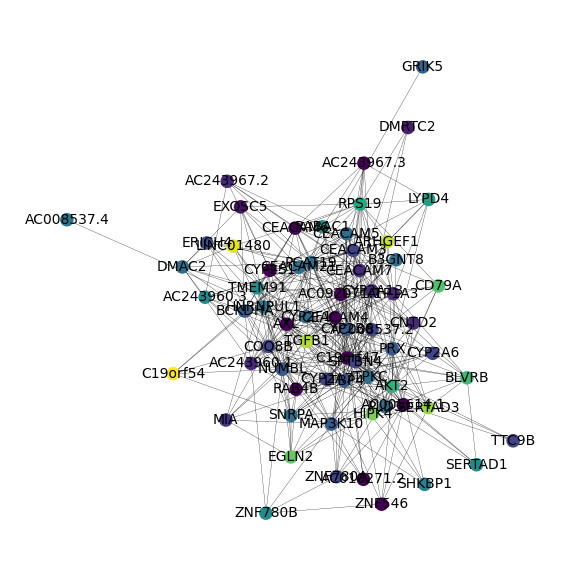

In [255]:
g = sg_gene.get_linegraph(s = 1, edges = False)
partition1 = community.best_partition(g)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

fig, ax = plt.subplots(figsize=(3, 3))
pos = nx.spring_layout(g)
offset = {k: (v[0], v[1] + 0.1) for k, v in pos.items()}  # Specify the desired offset
nx.draw(g, with_labels = True, node_size = 15, font_size=5, width = 0.1, cmap=cmap, node_color=list(partition.values()))
plt.axis('off')
plt.tight_layout()

# Show the plot
plt.show()

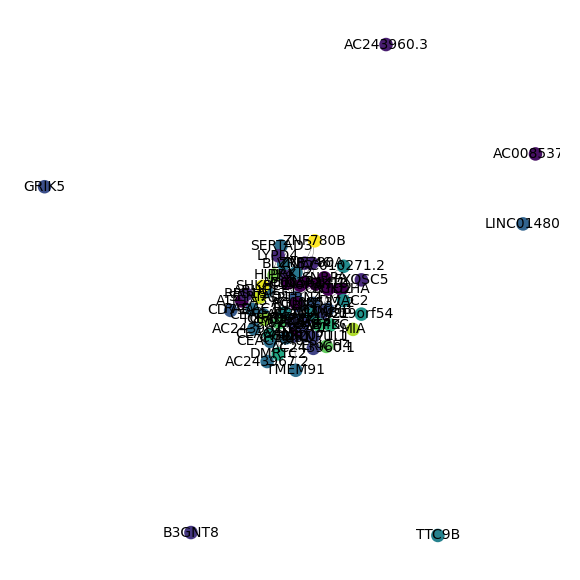

In [277]:
g = sg_gene.get_linegraph(s = 2, edges = False)
partition2 = community.best_partition(g)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

fig, ax = plt.subplots(figsize=(3, 3))
pos = nx.spring_layout(g)
offset = {k: (v[0], v[1] + 0.1) for k, v in pos.items()}  # Specify the desired offset
nx.draw(g, with_labels = True, node_size = 15, font_size=5, width = 0.1, cmap=cmap, node_color=list(partition.values()))
plt.axis('off')
plt.tight_layout()

# Show the plot
plt.show()

In [280]:
partition1.keys()
labels1 = list(partition1.values())
labels2 = [partition2[k] for k in list(partition1.keys())]

ari = adjusted_rand_score(labels1, labels2)
ari

print(labels1)
print(labels2)

[0, 0, 1, 0, 3, 3, 2, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 3, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 3, 1, 2, 3, 1, 1, 2, 3, 2, 2, 1, 0, 2, 3, 3, 3, 3, 3, 0, 0, 0, 1, 0, 0, 1, 3, 2, 2, 2, 3, 1, 2, 2, 0]
[2, 2, 3, 2, 6, 6, 2, 3, 3, 3, 2, 3, 2, 3, 3, 8, 2, 2, 3, 5, 6, 3, 3, 3, 5, 3, 5, 2, 5, 9, 5, 6, 3, 1, 6, 6, 3, 5, 6, 5, 5, 3, 2, 0, 6, 6, 6, 6, 6, 2, 2, 6, 3, 3, 2, 3, 6, 7, 3, 5, 6, 3, 5, 4, 3]


In [185]:
colSums_sg_gene = subgraphIncDF.sum()
sg_gene_multiEdge = subgraphIncDF.loc[:, colSums_sg_gene >=4]
sg_gene_multiEdge_HG = hnx.Hypergraph.from_incidence_dataframe(sg_gene_multiEdge)
print(sg_gene_multiEdge_HG.number_of_nodes(), sg_gene_multiEdge_HG.number_of_edges())

38 16


Text(0.5, 1.0, 'Gene subgraph-dual')

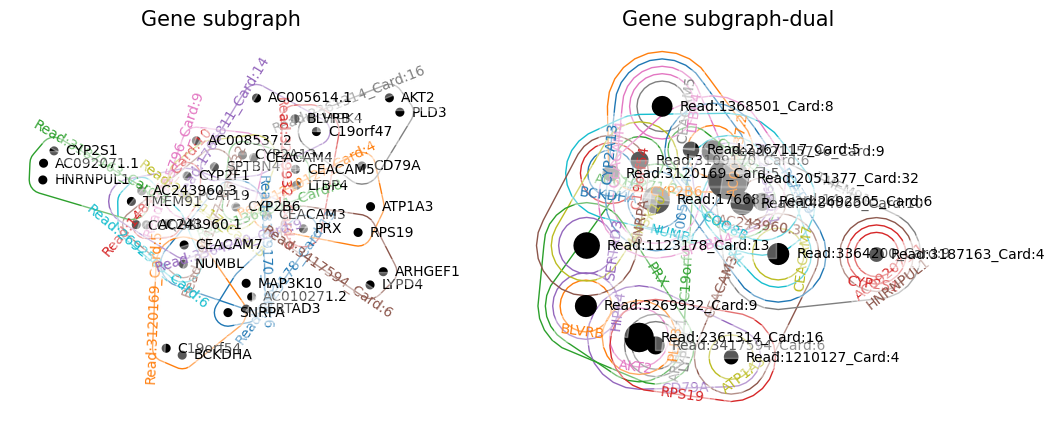

In [186]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
HD = sg_gene_multiEdge_HG.dual()
hnx.draw(sg_gene_multiEdge_HG,ax=ax[0])
ax[0].set_title("Gene subgraph",fontsize=15)
hnx.draw(HD,ax=ax[1])
ax[1].set_title("Gene subgraph-dual",fontsize=15)

<Axes: >

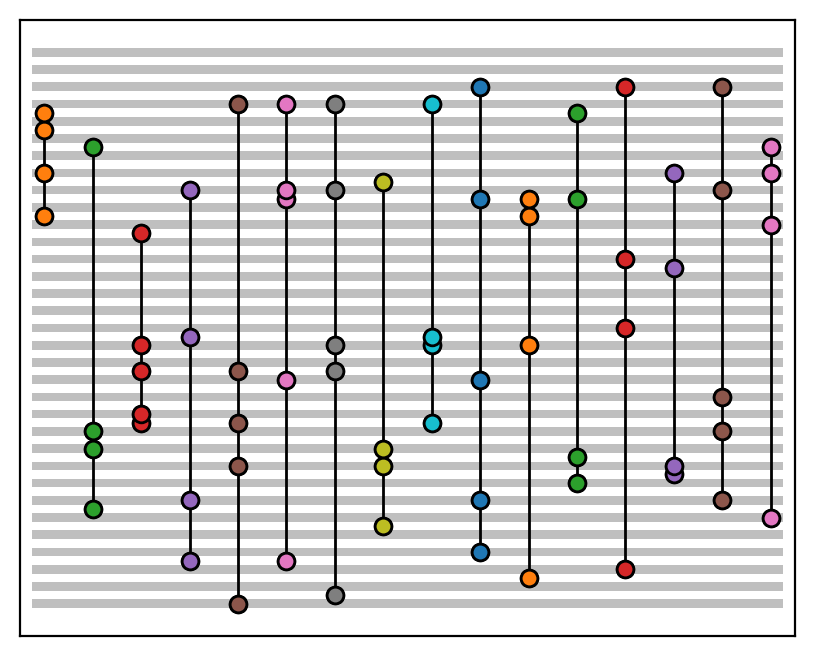

In [199]:
HG = HAT.Hypergraph(np.array(sg_gene_multiEdge))
plt.figure(figsize=(5,4))
HG.draw()